# 2. Convolutional Neural Network

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

class_Name = ['Afghan_hound','Airedale','basenji','Bernese_mountain_dog','Irish_wolfhound','Leonberg','Scottish_deerhound','Tibetan_terrier']
X_train = []
Y_train = []
X_test = []
Y_test = []

for root, dirs, files in os.walk("DL_HW1/stanford_dogs_dataset/train"):
  for dir in dirs:
    path = os.path.join(root,dir)
    for next_root, next_dirs, next_files in os.walk(path):
      for file in next_files:
        i = class_Name.index(dir)
        img = cv2.imread(os.path.join(path,file))
        img = cv2.resize(img, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
        X_train.append(np.asarray(img))
        Y_train.append(i)
X_train = np.asarray(X_train)
Y_train = np.asarray(Y_train)
X_train = X_train.astype('float32') / 255
Y_train = Y_train.astype('float32') 

print(X_train.shape)
print(Y_train.shape)

for root, dirs, files in os.walk("DL_HW1/stanford_dogs_dataset/test"):
  for dir in dirs:
    path = os.path.join(root,dir)
    for next_root, next_dirs, next_files in os.walk(path):
      for file in next_files:
        i = class_Name.index(dir)
        img = cv2.imread(os.path.join(path,file))
        img = cv2.resize(img, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
        X_test.append(np.asarray(img))
        Y_test.append(i)

X_test = np.asarray(X_test)
Y_test = np.asarray(Y_test)
X_test = X_test.astype('float32') / 255
Y_test = Y_test.astype('float32') 

print(X_test.shape)
print(Y_test.shape)


(1328, 224, 224, 3)
(1328,)
(288, 224, 224, 3)
(288,)


## (1) Please implement a CNN for image recognition by using Stanford Dogs Dataset,then plot the learning curve and the accuracy rate of training and test data. 

In [6]:
class CNN_Model(nn.Module):
  def __init__(self):
    super(CNN_Model, self).__init__()
    # Convolution 1 , input_shape=(3,224,224)
    self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=0) #output_shape=(16,220,220)
    self.relu1 = nn.ReLU() # activation
    # Max pool 1
    self.maxpool1 = nn.MaxPool2d(kernel_size=2) #output_shape=(16,110,110)
    # Convolution 2
    self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0) #output_shape=(32,106,106)
    self.relu2 = nn.ReLU() # activation
    # Max pool 2
    self.maxpool2 = nn.MaxPool2d(kernel_size=2) #output_shape=(32,53,53)
    # Fully connected 1 ,#input_shape=(32*4*4)
    self.fc1 = nn.Linear(32 * 53 * 53, 10) 

  def forward(self, x):
    out = self.cnn1(x)
    out = self.relu1(out)
    out = self.maxpool1(out)
    out = self.cnn2(out)
    out = self.relu2(out)
    out = self.maxpool2(out)
    out = out.view(out.size(0), -1)
    out = self.fc1(out)
    return out

def train_model(model, loss_func, optimizer, input_shape, num_epochs, train_loader, test_loader):
  training_loss = []
  training_accuracy = []
  testing_loss = []
  testing_accuracy = []
  for epoch in range(num_epochs):
    correct_train = 0
    total_train = 0
    for i, (images, labels) in enumerate(train_loader):
      train = images.view(input_shape).to(device) # 直接覆蓋成gpu版本而不是複製數值
      labels = labels.to(device)
      # Clear gradients
      optimizer.zero_grad()
      outputs = model(train)
      train_loss = loss_func(outputs, labels)
      train_loss.backward()
      optimizer.step()
      predicted = torch.max(outputs.data, 1)[1]
      total_train += len(labels)
      correct_train += (predicted == labels).float().sum()

    train_accuracy = 100 * correct_train / float(total_train)
    training_accuracy.append(train_accuracy)
    training_loss.append(train_loss.data)

    correct_test = 0
    total_test = 0
    for images, labels in test_loader:
      test = images.view(input_shape).to(device)
      labels = labels.to(device)
      outputs = model(test)
      test_loss = loss_func(outputs, labels)
      predicted = torch.max(outputs.data, 1)[1]
      total_test += len(labels)
      correct_test += (predicted == labels).sum()

    test_accuracy = 100 * correct_test.item() / total_test
    testing_accuracy.append(test_accuracy)
    testing_loss.append(test_loss.data)
    print('Train Epoch: {}/{} Traing_Loss: {} Traing_acc: {:.6f}% Test_Loss: {} Test_accuracy: {:.6f}%'.format(epoch+1, num_epochs, train_loss.data, train_accuracy, test_loss.data, test_accuracy))
  return training_loss, training_accuracy, testing_loss, testing_accuracy


In [7]:
#check gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# data 轉成 torch 的 tensor 形式
x_train = torch.from_numpy(X_train)
y_train = torch.from_numpy(Y_train).type(torch.LongTensor) # data type is long
x_test = torch.from_numpy(X_test)
y_test = torch.from_numpy(Y_test).type(torch.LongTensor) # data type is long

# 將input 數據與目標 output 打包
train = torch.utils.data.TensorDataset(x_train,y_train)
test = torch.utils.data.TensorDataset(x_test,y_test)

# Hyper Parameters
learningRate = 0.0001
batch_size = 100
num_epochs = 50

# Pytorch DataLoader
train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = True)

cnn_model = CNN_Model().to(device)
print(cnn_model)
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=learningRate,weight_decay=0.00001)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()   # the target label is not one-hotted
input_shape = (-1,3,224,224)

CNN_Model(
  (cnn1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=89888, out_features=10, bias=True)
)


Train Epoch: 1/50 Traing_Loss: 2.0768868923187256 Traing_acc: 13.253012% Test_Loss: 2.0940206050872803 Test_accuracy: 15.972222%
Train Epoch: 2/50 Traing_Loss: 1.9539912939071655 Traing_acc: 20.481928% Test_Loss: 2.069265604019165 Test_accuracy: 19.791667%
Train Epoch: 3/50 Traing_Loss: 2.0599467754364014 Traing_acc: 25.451807% Test_Loss: 2.048260450363159 Test_accuracy: 23.263889%
Train Epoch: 4/50 Traing_Loss: 1.9971929788589478 Traing_acc: 29.367468% Test_Loss: 2.044796943664551 Test_accuracy: 21.527778%
Train Epoch: 5/50 Traing_Loss: 1.9427783489227295 Traing_acc: 32.605419% Test_Loss: 1.9760737419128418 Test_accuracy: 25.694444%
Train Epoch: 6/50 Traing_Loss: 1.763013243675232 Traing_acc: 34.638554% Test_Loss: 1.9985138177871704 Test_accuracy: 20.486111%
Train Epoch: 7/50 Traing_Loss: 1.8638559579849243 Traing_acc: 36.822289% Test_Loss: 2.017777919769287 Test_accuracy: 22.916667%
Train Epoch: 8/50 Traing_Loss: 1.690536379814148 Traing_acc: 37.650600% Test_Loss: 1.949831485748291 T

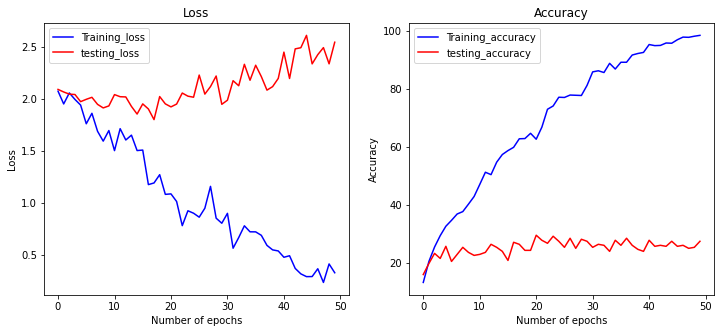

In [8]:
training_loss, training_accuracy, testing_loss, testing_accuracy = train_model(cnn_model, loss_func, optimizer, input_shape, num_epochs, train_loader, test_loader)
# visualization
plt.figure(figsize = (12, 5), dpi = 72)
plt.subplot(1,2,1)
plt.plot(range(num_epochs), np.array(torch.tensor(training_loss,device='cpu')), 'b-', label='Training_loss')
plt.plot(range(num_epochs), np.array(torch.tensor(testing_loss,device='cpu')) , 'r-', label='testing_loss')
plt.title('Loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(range(num_epochs), np.array(torch.tensor(training_accuracy,device='cpu')), 'b-', label='Training_accuracy')
plt.plot(range(num_epochs), np.array(torch.tensor(testing_accuracy,device='cpu')), 'r-', label='testing_accuracy')
plt.title('Accuracy')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
torch.cuda.empty_cache() # 釋放gpu

## (2) ResNet-18


### (a)

In [22]:
class RestNetBasicBlock(nn.Module):
    def __init__(self,in_channels, out_channels, stride):
        super(RestNetBasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride,padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels,out_channels,kernel_size=3,stride=stride,padding=1)
        self.bn2 =nn.BatchNorm2d(out_channels)
    def forward(self,x):
        out = self.conv1(x)
        out = F.relu(self.bn1(out))
        out = self.conv2(out)
        out = self.bn2(out)
        return F.relu(x + out)

class RestNetDownBlock(nn.Module):
    def __init__(self,in_channels, out_channels, stride):
        super(RestNetDownBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride[0],padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels,out_channels,kernel_size=3,stride=stride[1],padding=1)
        self.bn2 =nn.BatchNorm2d(out_channels)
        self.extra = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride[0],padding=0),
            nn.BatchNorm2d(out_channels)
        )
    def forward(self,x):
        extra_x = self.extra(x)
        out = self.conv1(x)
        out = F.relu(self.bn1(out))
        out = self.conv2(out)
        out = self.bn2(out)
        return F.relu(extra_x + out)

class ResNet18(nn.Module):
    def __init__(self):
         super(ResNet18, self).__init__()
         self.conv1 = nn.Conv2d(3,64,kernel_size=7,stride=2,padding=3)
         self.bn1 = nn.BatchNorm2d(64)
         self.maxpool1 = nn.MaxUnpool2d(kernel_size=3,stride=2,padding=1)
         self.layer1 = nn.Sequential(RestNetBasicBlock(64,64,1),RestNetBasicBlock(64,64,1))
         self.layer2 = nn.Sequential(RestNetDownBlock(64,128,[2,1]),RestNetBasicBlock(128,128,1))
         self.layer3 = nn.Sequential(RestNetDownBlock(128,256,[2,1]),RestNetBasicBlock(256,256,1))
         self.layer4 = nn.Sequential(RestNetDownBlock(256,512,[2,1]),RestNetBasicBlock(512,512,1))
         self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
         self.fc = nn.Linear(512,10)
    def forward(self,x):
        out =  self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.reshape(x.shape[0],-1)
        out = self.fc(out)
        return out

In [23]:
#check gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

x_train = torch.from_numpy(X_train)
y_train = torch.from_numpy(Y_train).type(torch.LongTensor) # data type is long
x_test = torch.from_numpy(X_test)
y_test = torch.from_numpy(Y_test).type(torch.LongTensor) # data type is long

train = torch.utils.data.TensorDataset(x_train,y_train)
test = torch.utils.data.TensorDataset(x_test,y_test)

# Hyper Parameters
learningRate = 0.001
batch_size = 50
num_epochs = 50

# Pytorch DataLoader
train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = True, num_workers=2)

res_model = ResNet18().to(device)
print(res_model)
optimizer = torch.optim.Adam(res_model.parameters(), lr=learningRate,weight_decay=0.00001)   
loss_func = nn.CrossEntropyLoss()  
input_shape = (-1,3,224,224)

ResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxUnpool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (layer1): Sequential(
    (0): RestNetBasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): RestNetBasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affin

In [24]:
def train_Res(model, loss_func, optimizer, input_shape, num_epochs, train_loader, test_loader):
    training_loss = []
    training_accuracy = []
    testing_loss = []
    testing_accuracy = []
    for epoch in range(num_epochs):
        correct_train = 0
        total_train = 0
        res_model.train()
        for i, (images, labels) in enumerate(train_loader):
            train = images.view(input_shape).to(device) # 直接覆蓋成gpu版本而不是複製數值
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = res_model(train)
            train_loss = loss_func(outputs, labels)
            train_loss.backward()
            optimizer.step()
            predicted = torch.max(outputs.data, 1)[1]
            total_train += len(labels)
            correct_train += (predicted == labels).float().sum()

        train_accuracy = 100 * correct_train / float(total_train)
        training_accuracy.append(train_accuracy)
        training_loss.append(train_loss.data)

        res_model.eval()
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for images, labels in test_loader:
                test = images.view(input_shape).to(device)
                labels = labels.to(device)
                outputs = res_model(test)
                test_loss = loss_func(outputs, labels)
                predicted = torch.max(outputs.data, 1)[1]
                total_test += len(labels)
                correct_test += (predicted == labels).float().sum()

            test_accuracy = 100 * correct_test / float(total_test)
            testing_accuracy.append(test_accuracy)
            testing_loss.append(test_loss.data)
        print('Train Epoch: {}/{} Traing_Loss: {} Traing_acc: {:.6f}% Test_Loss: {} Test_accuracy: {:.6f}%'.format(epoch+1, num_epochs, train_loss.data, train_accuracy, test_loss.data, test_accuracy))
    return training_loss, training_accuracy, testing_loss, testing_accuracy

Train Epoch: 1/50 Traing_Loss: 2.028308391571045 Traing_acc: 13.780120% Test_Loss: 2.930332660675049 Test_accuracy: 15.625000%
Train Epoch: 2/50 Traing_Loss: 2.073014736175537 Traing_acc: 20.406626% Test_Loss: 2.2667572498321533 Test_accuracy: 19.444445%
Train Epoch: 3/50 Traing_Loss: 2.1583192348480225 Traing_acc: 22.515059% Test_Loss: 2.6010329723358154 Test_accuracy: 17.013889%
Train Epoch: 4/50 Traing_Loss: 1.919053077697754 Traing_acc: 24.171686% Test_Loss: 1.9403409957885742 Test_accuracy: 23.263889%
Train Epoch: 5/50 Traing_Loss: 2.202812910079956 Traing_acc: 25.150602% Test_Loss: 1.927065372467041 Test_accuracy: 26.041666%
Train Epoch: 6/50 Traing_Loss: 1.988413691520691 Traing_acc: 24.472891% Test_Loss: 1.984851598739624 Test_accuracy: 21.875000%
Train Epoch: 7/50 Traing_Loss: 1.919793725013733 Traing_acc: 25.903614% Test_Loss: 2.0711917877197266 Test_accuracy: 20.138889%
Train Epoch: 8/50 Traing_Loss: 1.889547348022461 Traing_acc: 26.807228% Test_Loss: 1.9999622106552124 Test

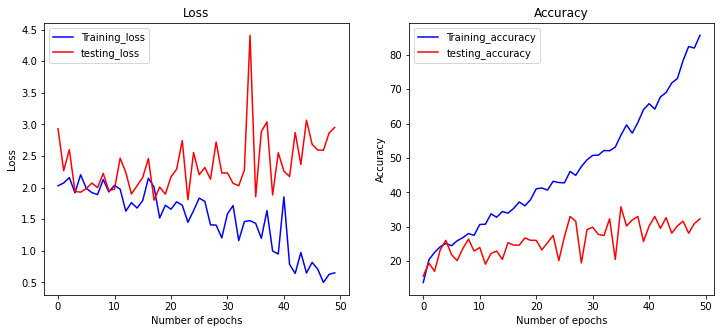

In [25]:
training_loss, training_accuracy, testing_loss, testing_accuracy = train_Res(res_model, loss_func, optimizer, input_shape, num_epochs, train_loader, test_loader)
# visualization
plt.figure(figsize = (12, 5), dpi = 72)
plt.subplot(1,2,1)
plt.plot(range(num_epochs), np.array(torch.tensor(training_loss,device='cpu')), 'b-', label='Training_loss')
plt.plot(range(num_epochs), np.array(torch.tensor(testing_loss,device='cpu')) , 'r-', label='testing_loss')
plt.title('Loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(range(num_epochs), np.array(torch.tensor(training_accuracy,device='cpu')), 'b-', label='Training_accuracy')
plt.plot(range(num_epochs), np.array(torch.tensor(testing_accuracy,device='cpu')), 'r-', label='testing_accuracy')
plt.title('Accuracy')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
torch.cuda.empty_cache() # 釋放gpu

### (b) 
雖然(a)小題結果很明顯因為數據集太小導致overfitting，但通過移除identity可以發現，因為模型太深梯度消失無法有效更新淺層參數會導致Accuracy振盪變大，且導致Degradation，造成許多冗餘層，在最後epoch accuracy下降許多。

In [36]:
class RestNetBasicBlock(nn.Module):
    def __init__(self,in_channels, out_channels, stride):
        super(RestNetBasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride,padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels,out_channels,kernel_size=3,stride=stride,padding=1)
        self.bn2 =nn.BatchNorm2d(out_channels)
    def forward(self,x):
        output = self.conv1(x)
        output = F.relu(self.bn1(output))
        output = self.conv2(output)
        output = self.bn2(output)
        return output #change

class RestNetDownBlock(nn.Module):
    def __init__(self,in_channels, out_channels, stride):
        super(RestNetDownBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride[0],padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels,out_channels,kernel_size=3,stride=stride[1],padding=1)
        self.bn2 =nn.BatchNorm2d(out_channels)
        self.extra = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride[0],padding=0),
            nn.BatchNorm2d(out_channels)
        )
    def forward(self,x):
        extra_x = self.extra(x)
        output = self.conv1(x)
        output = F.relu(self.bn1(output))
        output = self.conv2(output)
        output = self.bn2(output)
        return F.relu(output) #change

class ResNet18(nn.Module):
    def __init__(self):
        super(ResNet18, self).__init__()
        self.conv1 = nn.Conv2d(3,64,kernel_size=7,stride=2,padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool1 = nn.MaxUnpool2d(kernel_size=3,stride=2,padding=1)

        self.layer1 = nn.Sequential(RestNetBasicBlock(64,64,1),RestNetBasicBlock(64,64,1))
        self.layer2 = nn.Sequential(RestNetDownBlock(64,128,[2,1]),RestNetBasicBlock(128,128,1))
        self.layer3 = nn.Sequential(RestNetDownBlock(128,256,[2,1]),RestNetBasicBlock(256,256,1))
        self.layer4 = nn.Sequential(RestNetDownBlock(256,512,[2,1]),RestNetBasicBlock(512,512,1))
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.fc = nn.Linear(512,10)
    def forward(self,x):
        out =  self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.reshape(x.shape[0],-1)
        out = self.fc(out)
        return out

In [37]:
# data 轉成 torch 的 tensor 形式
x_train = torch.from_numpy(X_train)
y_train = torch.from_numpy(Y_train).type(torch.LongTensor) # data type is long
x_test = torch.from_numpy(X_test)
y_test = torch.from_numpy(Y_test).type(torch.LongTensor) # data type is long

# 將input 數據與目標 output 打包
train = torch.utils.data.TensorDataset(x_train,y_train)
test = torch.utils.data.TensorDataset(x_test,y_test)

# Hyper Parameters
learningRate = 0.001
batch_size = 50
num_epochs = 50

# Pytorch DataLoader
train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = True, num_workers=2)

res_model = ResNet18().to(device)
print(res_model)
optimizer = torch.optim.Adam(res_model.parameters(), lr=learningRate,weight_decay=0.00001)   
loss_func = nn.CrossEntropyLoss() 
input_shape = (-1,3,224,224)

ResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxUnpool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (layer1): Sequential(
    (0): RestNetBasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): RestNetBasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affin

In [38]:
def train_Res(model, loss_func, optimizer, input_shape, num_epochs, train_loader, test_loader):
    training_loss = []
    training_accuracy = []
    testing_loss = []
    testing_accuracy = []
    for epoch in range(num_epochs):
        correct_train = 0
        total_train = 0
        res_model.train()
        for i, (images, labels) in enumerate(train_loader):
            train = images.view(input_shape).to(device) # 直接覆蓋成gpu版本而不是複製數值
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = res_model(train)
            train_loss = loss_func(outputs, labels)
            train_loss.backward()
            optimizer.step()
            predicted = torch.max(outputs.data, 1)[1]
            total_train += len(labels)
            correct_train += (predicted == labels).float().sum()

        train_accuracy = 100 * correct_train / float(total_train)
        training_accuracy.append(train_accuracy)
        training_loss.append(train_loss.data)

        res_model.eval()
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for images, labels in test_loader:
                test = images.view(input_shape).to(device)
                labels = labels.to(device)
                outputs = res_model(test)
                test_loss = loss_func(outputs, labels)
                predicted = torch.max(outputs.data, 1)[1]
                total_test += len(labels)
                correct_test += (predicted == labels).float().sum()
            test_accuracy = 100 * correct_test / float(total_test)
            testing_accuracy.append(test_accuracy)
            testing_loss.append(test_loss.data)
        print('Train Epoch: {}/{} Traing_Loss: {} Traing_acc: {:.6f}% Test_Loss: {} Test_accuracy: {:.6f}%'.format(epoch+1, num_epochs, train_loss.data, train_accuracy, test_loss.data, test_accuracy))
    return training_loss, training_accuracy, testing_loss, testing_accuracy

Train Epoch: 1/50 Traing_Loss: 2.182391881942749 Traing_acc: 15.361445% Test_Loss: 2.682844400405884 Test_accuracy: 17.013889%
Train Epoch: 2/50 Traing_Loss: 2.212743043899536 Traing_acc: 19.051205% Test_Loss: 2.370436429977417 Test_accuracy: 17.708334%
Train Epoch: 3/50 Traing_Loss: 2.2988665103912354 Traing_acc: 21.159637% Test_Loss: 2.1980135440826416 Test_accuracy: 18.750000%
Train Epoch: 4/50 Traing_Loss: 2.0050675868988037 Traing_acc: 20.406626% Test_Loss: 2.034228801727295 Test_accuracy: 20.833334%
Train Epoch: 5/50 Traing_Loss: 1.9715863466262817 Traing_acc: 22.515059% Test_Loss: 2.0729520320892334 Test_accuracy: 18.750000%
Train Epoch: 6/50 Traing_Loss: 1.9719122648239136 Traing_acc: 20.707830% Test_Loss: 1.9883358478546143 Test_accuracy: 22.569445%
Train Epoch: 7/50 Traing_Loss: 2.0030694007873535 Traing_acc: 21.611444% Test_Loss: 2.0598151683807373 Test_accuracy: 21.875000%
Train Epoch: 8/50 Traing_Loss: 1.9399524927139282 Traing_acc: 24.322289% Test_Loss: 2.20573353767395 T

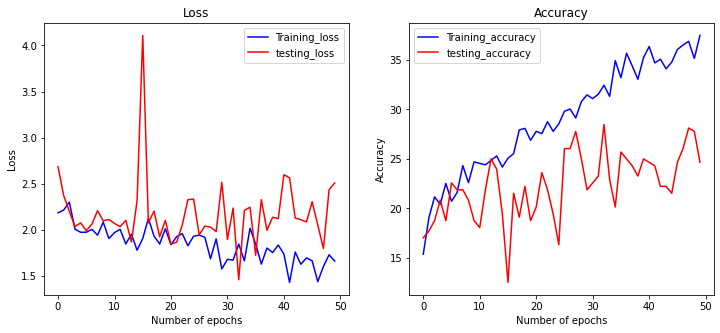

In [39]:
training_loss, training_accuracy, testing_loss, testing_accuracy = train_Res(res_model, loss_func, optimizer, input_shape, num_epochs, train_loader, test_loader)
# visualization
plt.figure(figsize = (12, 5), dpi = 72)
plt.subplot(1,2,1)
plt.plot(range(num_epochs), np.array(torch.tensor(training_loss,device='cpu')), 'b-', label='Training_loss')
plt.plot(range(num_epochs), np.array(torch.tensor(testing_loss,device='cpu')) , 'r-', label='testing_loss')
plt.title('Loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(range(num_epochs), np.array(torch.tensor(training_accuracy,device='cpu')), 'b-', label='Training_accuracy')
plt.plot(range(num_epochs), np.array(torch.tensor(testing_accuracy,device='cpu')), 'r-', label='testing_accuracy')
plt.title('Accuracy')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
torch.cuda.empty_cache() # 釋放gpu